In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "model")))

from BoostingTrees import GradientBoostingClassifier


In [47]:
def print_classification_metrics(y_true, y_pred, y_proba=None):
    acc = np.mean(y_true == y_pred)
    precision = np.sum((y_true == 1) & (y_pred == 1)) / (np.sum(y_pred == 1) + 1e-8)
    recall = np.sum((y_true == 1) & (y_pred == 1)) / (np.sum(y_true == 1) + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    mse = np.mean((y_true - y_proba)**2)
    mae = np.mean(np.abs(y_true - y_proba))
    r2 = 1 - np.sum((y_true - y_proba)**2) / np.sum((y_true - np.mean(y_true))**2)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

def plot_decision_boundary(model, X, y):
    if X.shape[1] != 2:
        print("Skipping decision boundary: only works for 2D data.")
        return
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.5, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title("Decision Boundary")
    plt.show()


In [48]:
import pandas as pd

def load_dataset(path, label_col):
    df = pd.read_csv(path)
    X = df.drop(columns=[label_col]).values
    y = df[label_col].values
    return X, y

datasets = {
    "Classification Data": load_dataset("../tests/classification_data.csv", "label"),
    "IBM Attrition": load_dataset("../tests/ibm_attrition.csv", "Attrition"),
    "Moon Data": load_dataset("../tests/moon_classification_data.csv", "label"),
    "Circle Data": load_dataset("../tests/circle_classification_data.csv", "label"),
}

print("Loaded datasets:", list(datasets.keys()))


Loaded datasets: ['Classification Data', 'IBM Attrition', 'Moon Data', 'Circle Data']


In [49]:
import pandas as pd
import numpy as np
from collections import Counter

results = {}

for name, (X_raw, y) in datasets.items():
    print(f"\n Training on: {name}")

    if not isinstance(X_raw, pd.DataFrame):
        X_raw = pd.DataFrame(X_raw)

    
    if name == "IBM Attrition":
        print(" Class distribution:", dict(Counter(y)))

        if "EmployeeNumber" in X_raw.columns:
            X_raw = X_raw.drop("EmployeeNumber", axis=1)

        X_raw = pd.get_dummies(X_raw, drop_first=True)

    else:
        non_numeric = X_raw.select_dtypes(exclude=[np.number])
        if not non_numeric.empty:
            print(f" Non-numeric columns found in {name}: {list(non_numeric.columns)}. Dropping them.")
            X_raw = X_raw.select_dtypes(include=[np.number])

    X = X_raw.values

    if X.shape[1] == 0:
        print(f" Skipping {name} because it has no numeric features.")
        continue

    n_features = X.shape[1]
    max_features = 1 if n_features < 2 else 'sqrt'

    model = GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=2,
        max_features=max_features
    )

    model.fit(X, y)
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    results[name] = {
        "X": X,
        "y": y,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "model": model,
    }

print("\n Models trained for all datasets.")



 Training on: Classification Data

 Training on: IBM Attrition
 Class distribution: {np.int64(1): 237, np.int64(0): 1233}

 Training on: Moon Data

 Training on: Circle Data

 Models trained for all datasets.


In [51]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    return tp / (tp + fp + 1e-8)

def recall_score(y_true, y_pred):
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    return tp / (tp + fn + 1e-8)

def f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall + 1e-8)

def log_loss(y_true, y_proba):
    eps = 1e-15
    y_proba = np.clip(y_proba, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_proba) + (1 - y_true) * np.log(1 - y_proba))

def mean_squared_error(y_true, y_proba):
    return np.mean((y_true - y_proba) ** 2)

def mean_absolute_error(y_true, y_proba):
    return np.mean(np.abs(y_true - y_proba))

def r2_score(y_true, y_proba):
    ss_res = np.sum((y_true - y_proba) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + 1e-8)

for name, res in results.items():
    X, y, y_pred, y_proba = res["X"], res["y"], res["y_pred"], res["y_proba"]
    
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(prec, rec)
    logloss = log_loss(y, y_proba)
    mse = mean_squared_error(y, y_proba)
    mae = mean_absolute_error(y, y_proba)
    r2 = r2_score(y, y_proba)

    print(f"\n Metrics for {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")



 Metrics for Classification Data
Accuracy: 0.9240
Precision: 0.9258
Recall: 0.9258
F1 Score: 0.9258
Log Loss: 0.2833
MSE: 0.0763
MAE: 0.2279
R² Score: 0.6947

 Metrics for IBM Attrition
Accuracy: 0.8388
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Log Loss: 0.3735
MSE: 0.1176
MAE: 0.2262
R² Score: 0.1301

 Metrics for Moon Data
Accuracy: 0.8920
Precision: 0.8920
Recall: 0.8920
F1 Score: 0.8920
Log Loss: 0.2353
MSE: 0.0737
MAE: 0.1589
R² Score: 0.7052

 Metrics for Circle Data
Accuracy: 0.8970
Precision: 0.8885
Recall: 0.9080
F1 Score: 0.8981
Log Loss: 0.2796
MSE: 0.0812
MAE: 0.1989
R² Score: 0.6750


 Saved: ..\notebooks\images\decision_boundary_-_moon_data.png


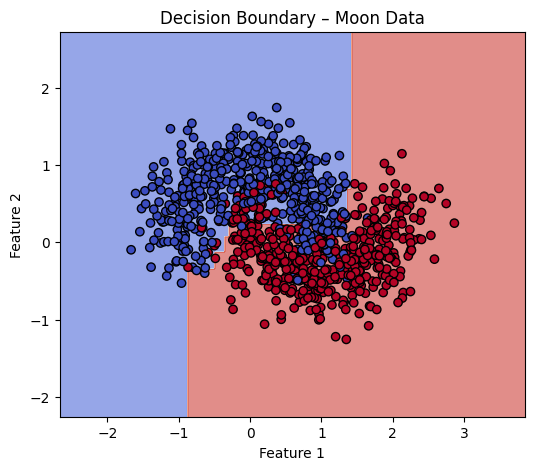

 Saved: ..\notebooks\images\decision_boundary_-_circle_data.png


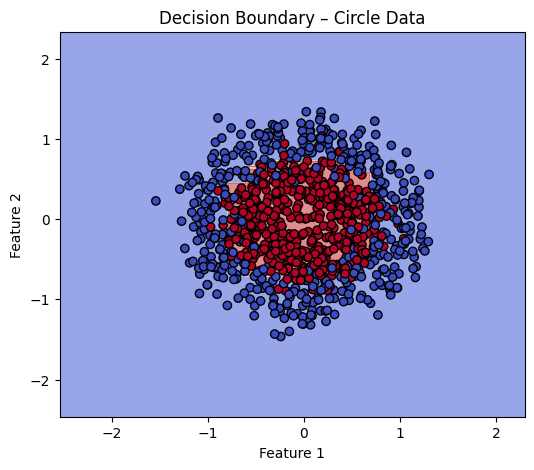

In [52]:
import matplotlib.pyplot as plt
import os

def plot_and_save_and_show_decision_boundary(model_fn, X, y, title):
    output_dir = os.path.join("..", "notebooks", "images")
    os.makedirs(output_dir, exist_ok=True)

    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model_fn(grid)
    zz = zz.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    filename = title.lower().replace(" ", "_").replace("–", "-") + ".png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    print(f" Saved: {filepath}")
    plt.show()

for name in ["Moon Data", "Circle Data"]:
    if name not in results:
        continue

    res = results[name]
    model = res["model"]

    def safe_predict(X_input, m=model):
        if m.normalize:
            X_input = (X_input - m.mean) / m.std
        y_pred = np.full(X_input.shape[0], 0.0)
        for tree in m.trees:
            y_pred += m.learning_rate * tree.predict(X_input)
        proba = 1 / (1 + np.exp(-y_pred))
        return (proba >= 0.5).astype(int)

    plot_and_save_and_show_decision_boundary(safe_predict, res["X"], res["y"], f"Decision Boundary – {name}")



 Generating plots for Classification Data
 Saved: ..\notebooks\images\classification_data_-_confusion_matrix_confusion_matrix.png


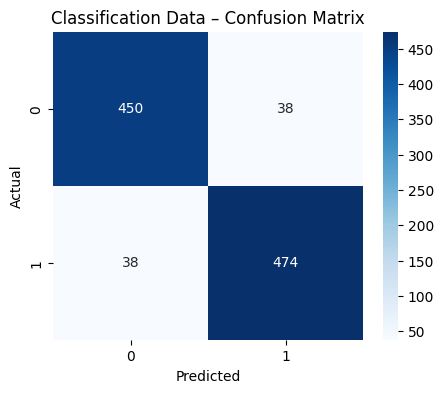

 Saved: ..\notebooks\images\classification_data_proba_hist.png


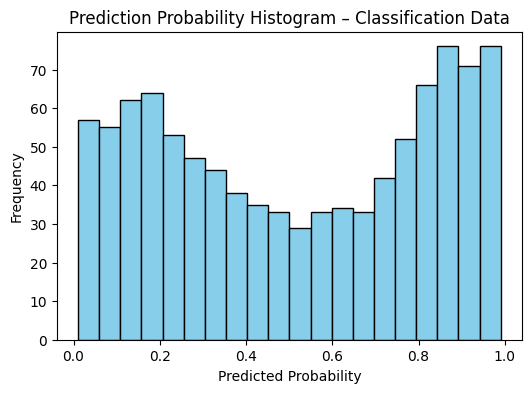


 Generating plots for IBM Attrition
 Saved: ..\notebooks\images\ibm_attrition_-_confusion_matrix_confusion_matrix.png


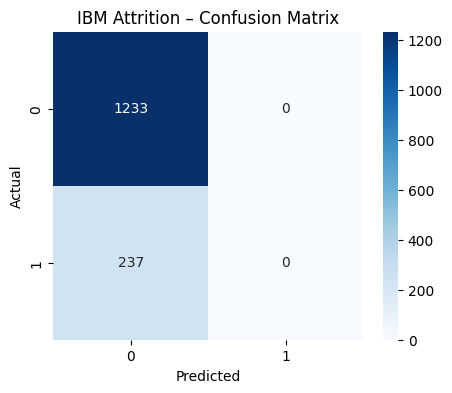

 Saved: ..\notebooks\images\ibm_attrition_proba_hist.png


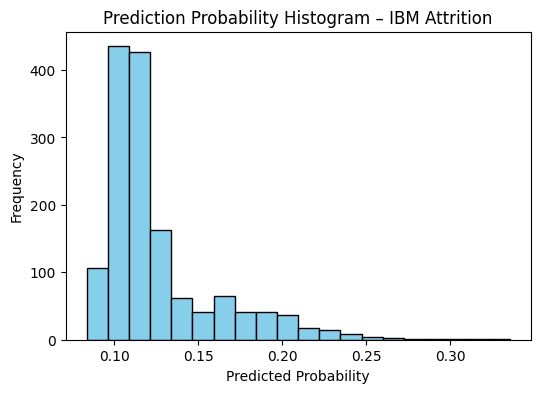


 Generating plots for Moon Data
 Saved: ..\notebooks\images\moon_data_-_confusion_matrix_confusion_matrix.png


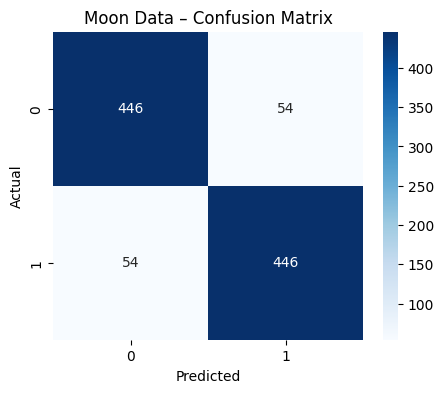

 Saved: ..\notebooks\images\moon_data_proba_hist.png


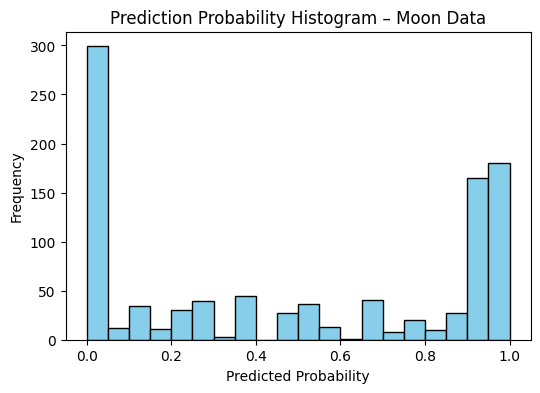


 Generating plots for Circle Data
 Saved: ..\notebooks\images\circle_data_-_confusion_matrix_confusion_matrix.png


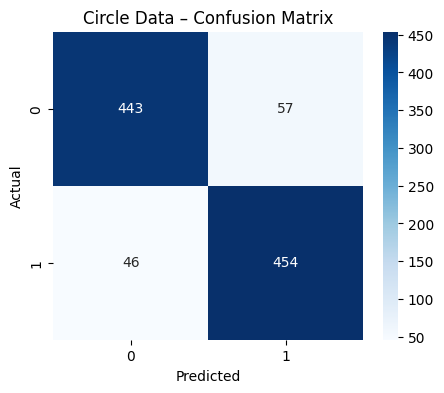

 Saved: ..\notebooks\images\circle_data_proba_hist.png


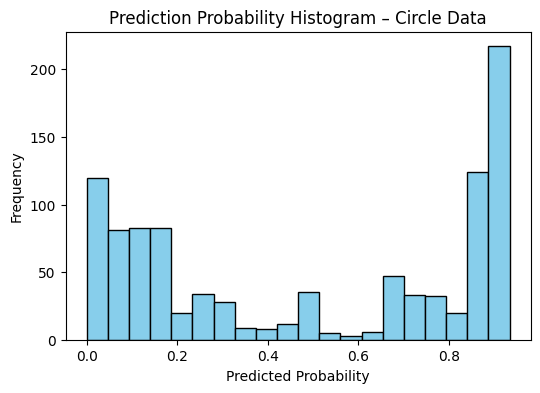

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_and_save_confusion_matrix(y_true, y_pred, title):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ["0", "1"]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)

    output_dir = os.path.join("..", "notebooks", "images")
    os.makedirs(output_dir, exist_ok=True)
    filename = title.lower().replace(" ", "_").replace("–", "-") + "_confusion_matrix.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    print(f" Saved: {filepath}")
    plt.show()

def plot_and_save_probability_histogram(y_proba, title):
    plt.figure(figsize=(6, 4))
    plt.hist(y_proba, bins=20, color="skyblue", edgecolor="k")
    plt.title(f"Prediction Probability Histogram – {title}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")

    output_dir = os.path.join("..", "notebooks", "images")
    os.makedirs(output_dir, exist_ok=True)
    filename = title.lower().replace(" ", "_").replace("–", "-") + "_proba_hist.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    print(f" Saved: {filepath}")
    plt.show()

for name, res in results.items():
    print(f"\n Generating plots for {name}")
    plot_and_save_confusion_matrix(res["y"], res["y_pred"], f"{name} – Confusion Matrix")
    plot_and_save_probability_histogram(res["y_proba"], f"{name}")



 Generating ROC Curve for Classification Data
 Saved: ..\notebooks\images\classification_data_roc_curve.png


C:\Users\gnupu\AppData\Local\Temp\ipykernel_19272\2692296840.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(tpr, fpr)


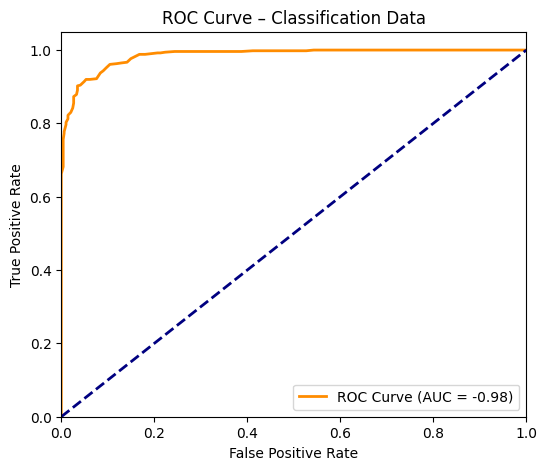


 Generating ROC Curve for IBM Attrition
 Saved: ..\notebooks\images\ibm_attrition_roc_curve.png


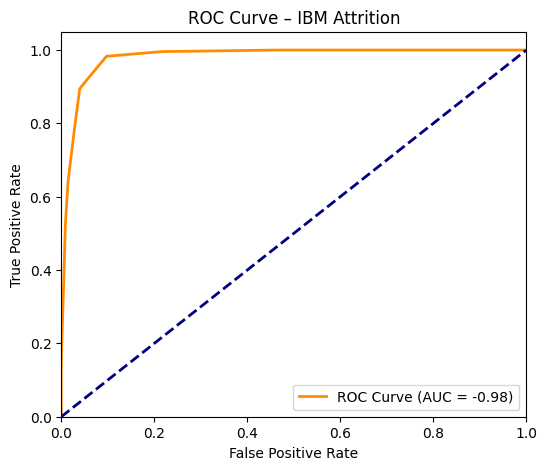


 Generating ROC Curve for Moon Data
 Saved: ..\notebooks\images\moon_data_roc_curve.png


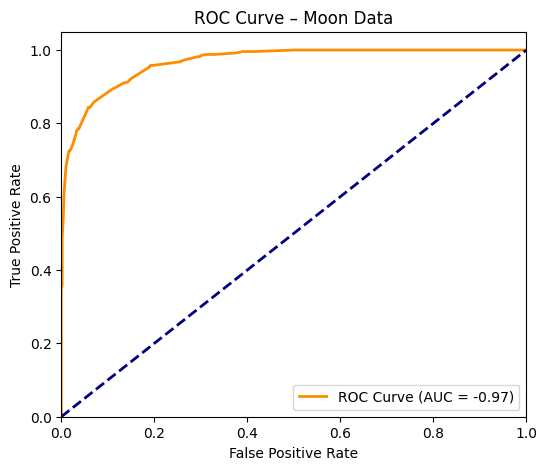


 Generating ROC Curve for Circle Data
 Saved: ..\notebooks\images\circle_data_roc_curve.png


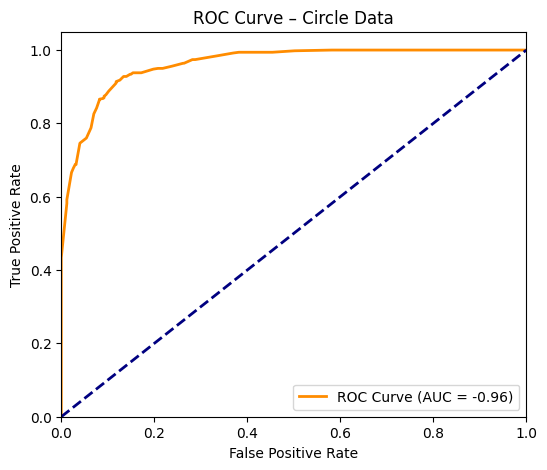

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import os

def compute_roc_points(y_true, y_proba, thresholds=100):
    thresholds = np.linspace(0, 1, thresholds)
    tpr_list = []
    fpr_list = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tp = ((y_true == 1) & (y_pred == 1)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()
        tn = ((y_true == 0) & (y_pred == 0)).sum()

        tpr = tp / (tp + fn + 1e-8)
        fpr = fp / (fp + tn + 1e-8)

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list)

def compute_auc(fpr, tpr):
    return np.trapz(tpr, fpr)

def plot_and_save_roc_curve_manual(y_true, y_proba, title):
    fpr, tpr = compute_roc_points(y_true, y_proba)
    auc_score = compute_auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {title}")
    plt.legend(loc="lower right")

    output_dir = os.path.join("..", "notebooks", "images")
    os.makedirs(output_dir, exist_ok=True)
    filename = title.lower().replace(" ", "_").replace("–", "-") + "_roc_curve.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    print(f" Saved: {filepath}")
    plt.show()

for name, res in results.items():
    print(f"\n Generating ROC Curve for {name}")
    plot_and_save_roc_curve_manual(res["y"], res["y_proba"], name)


 Saved: ..\notebooks\images\learning_curve_moon_data.png


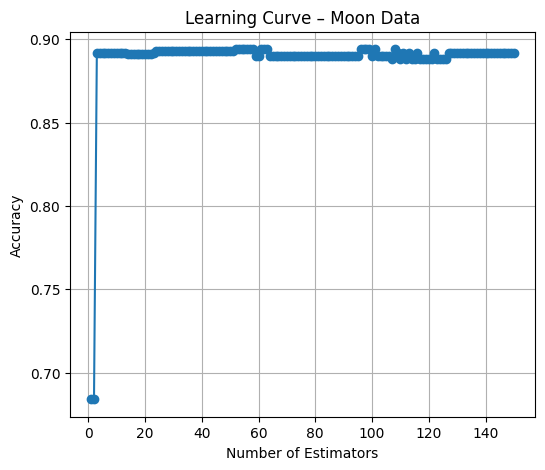

 Saved: ..\notebooks\images\learning_curve_circle_data.png


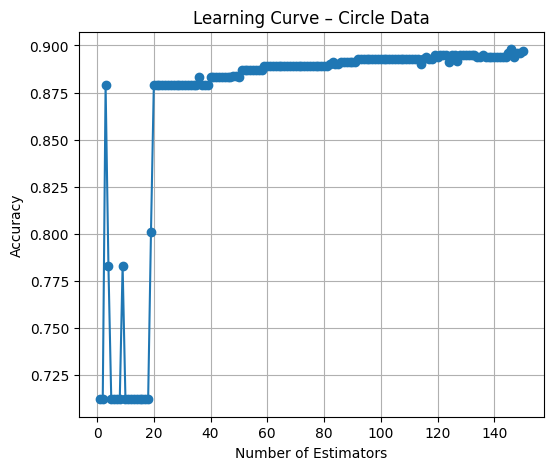

In [56]:
import matplotlib.pyplot as plt
import os

def plot_learning_curve(name, model):
    output_dir = os.path.join("..", "notebooks", "images")
    os.makedirs(output_dir, exist_ok=True)

    accuracies = []
    y_true = results[name]["y"]
    X_input = results[name]["X"]

    if model.normalize:
        X_input = (X_input - model.mean) / model.std

    y_pred = np.full(y_true.shape, 0.0)

    for i, tree in enumerate(model.trees, 1):
        y_pred += model.learning_rate * tree.predict(X_input)
        predicted_labels = (1 / (1 + np.exp(-y_pred)) >= 0.5).astype(int)
        acc = np.mean(predicted_labels == y_true)
        accuracies.append(acc)

    plt.figure(figsize=(6, 5))
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
    plt.title(f"Learning Curve – {name}")
    plt.xlabel("Number of Estimators")
    plt.ylabel("Accuracy")
    plt.grid(True)

    filename = f"learning_curve_{name.lower().replace(' ', '_').replace('–', '-')}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    print(f" Saved: {filepath}")
    plt.show()

for name in ["Moon Data", "Circle Data"]:
    if name in results:
        plot_learning_curve(name, results[name]["model"])


 Saved: ..\notebooks\images\probability_histogram_moon_data.png


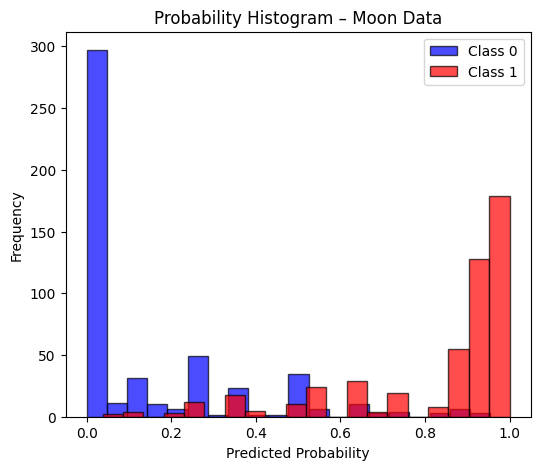

 Saved: ..\notebooks\images\probability_histogram_circle_data.png


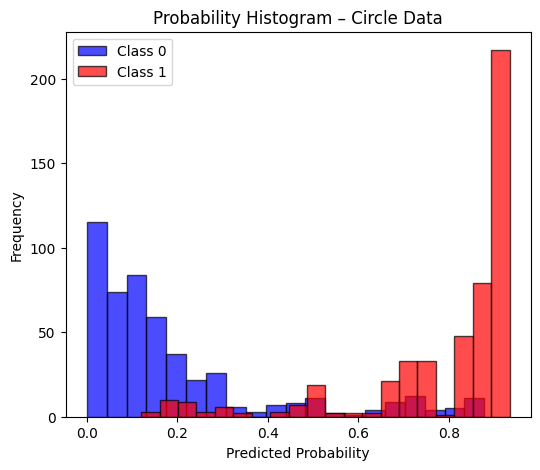

In [57]:
import matplotlib.pyplot as plt
import os

def plot_histogram_of_probabilities(name, y_proba, y_true):
    output_dir = os.path.join("..", "notebooks", "images")
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    plt.hist(y_proba[y_true == 0], bins=20, alpha=0.7, label='Class 0', color='blue', edgecolor='k')
    plt.hist(y_proba[y_true == 1], bins=20, alpha=0.7, label='Class 1', color='red', edgecolor='k')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.title(f"Probability Histogram – {name}")
    plt.legend()

    filename = f"probability_histogram_{name.lower().replace(' ', '_').replace('–', '-')}.png"
    filepath = os.path.join("..", "notebooks", "images", filename)
    plt.savefig(filepath)
    print(f" Saved: {filepath}")
    plt.show()

for name in ["Moon Data", "Circle Data"]:
    if name in results:
        plot_histogram_of_probabilities(name, results[name]["y_proba"], results[name]["y"])
